Imports

In [24]:
import os
import pickle

import matplotlib as mpl

mpl.rcParams['hatch.linewidth'] = 7

import matplotlib.pyplot as plt
import pandas as pd

Load data

In [25]:
res_dir = 'sch_mlp'

In [27]:
results = []
for file in os.listdir(res_dir):
    if not file.endswith('.pkl'):
        continue

    path = os.path.join(res_dir, file)
    with open(path, 'rb') as f:
        res = pickle.load(f)
        results.append(res)

In [28]:
armeni = False

In [29]:
if armeni:
    flattened_data = []
    for entry in results:
        for subj_id, regions in entry.items():
            for region_name, accuracy in regions.items():
                flattened_data.append({
                    'subj': subj_id,
                    'region_name': region_name,
                    'acc': accuracy
                })

    res = pd.DataFrame(flattened_data)
else:
    res= pd.DataFrame.from_records([{'region_name': reg_name, 'acc': acc} for res in results for r in res for reg_name, acc in r.items()])

In [30]:
region_names = res.region_name.unique()
div_regions_renamed = {div_name: div_name.replace(' division', '') for div_name in region_names if
                       'division' in div_name}
part_regions_renamed = {part_name: part_name.replace(' part', '') for part_name in region_names if 'part' in part_name}
res.region_name = res.region_name.replace({'baseline': 'Baseline',
                                           'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)': 'Juxtapositional Lobule Cortex',
                                           "Heschl's Gyrus (includes H1 and H2)": "Heschl's Gyrus"}
                                          | div_regions_renamed | part_regions_renamed)

In [31]:
n_region_appearances = res.groupby('region_name').apply(len)
rel_regions = n_region_appearances[n_region_appearances == n_region_appearances.max()].index
res = res[res.region_name.isin(rel_regions)]

/tmp/ipykernel_2938495/3350300543.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  n_region_appearances = res.groupby('region_name').apply(len)


In [32]:
res.index

RangeIndex(start=0, stop=245, step=1)

In [33]:
# res = res[res.subj == '001']

In [34]:
res = res.groupby('region_name').acc.aggregate(['mean', ('std', lambda x: x.std(ddof=1))]).dropna().sort_values('mean',
                                                                                                                ascending=False)

In [35]:
region_categories = {
    'attention': [
        'Cingulate Gyrus, anterior',
        'Cingulate Gyrus, posterior',
        'Frontal Pole',
        'Paracingulate Gyrus',
    ],
    'speech': [
        'Insular Cortex',
    ],
    'auditory': [
        'Insular Cortex',
        'Planum Polare',
    ],
    'Semantic/Lexical': [
        'Central Opercular Cortex',
        'Middle Frontal Gyrus',
        'Planum Polare',
        'Temporal Pole',
    ],
}

In [36]:
color_map = plt.get_cmap('tab10')
category_colors = {category: color_map(i) for i, category in enumerate(region_categories.keys())}
category_colors['other'] = 'gray'
category_colors['Baseline'] = color_map(len(region_categories))

In [37]:
def get_color_and_hatch(region):
    if region == 'Baseline':
        return category_colors['Baseline'], '', None

    associated_categories = [cat for cat, regions in region_categories.items() if region in regions]

    if not associated_categories:
        return category_colors['other'], '', None
    elif len(associated_categories) == 1:
        return category_colors[associated_categories[0]], '', None
    else:
        # For multiple associations, use the first color as base and create hatches for others
        base_color = category_colors[associated_categories[0]]
        hatch_colors = [category_colors[cat] for cat in associated_categories[1:]]
        hatch = '/' * len(hatch_colors)
        return base_color, hatch, hatch_colors


# Prepare colors and hatches
colors, hatches, hatch_colors_list = zip(*[get_color_and_hatch(region) for region in res.index])

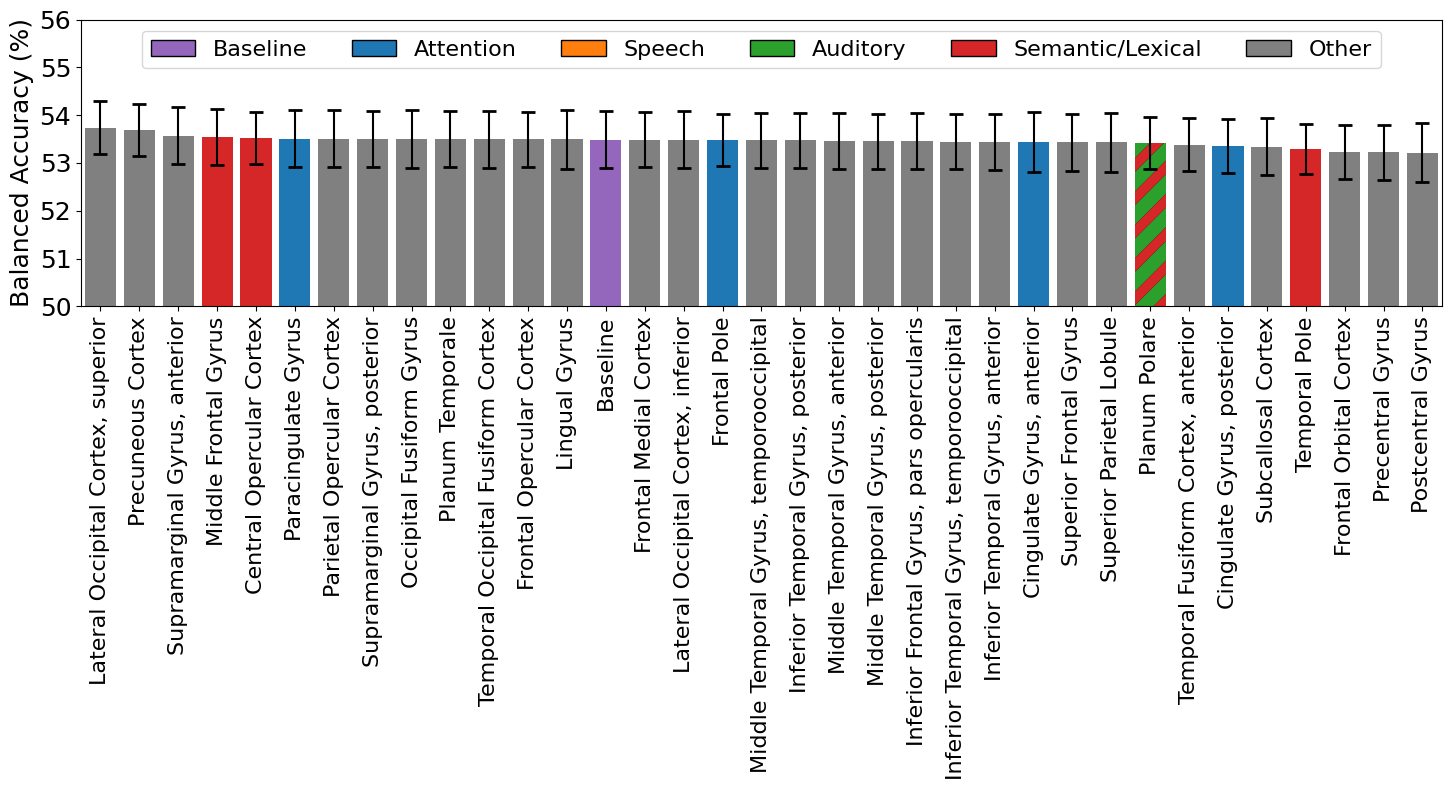

In [42]:
fig, ax = plt.subplots(figsize=(15, 8))
bars = ax.bar(
    res.index,
    res['mean'] * 100,
    yerr=res['std'] * 100,
    color=colors,
    capsize=5,
    error_kw={'ecolor': 'black', 'capthick': 2}
)

# Apply hatching with multiple colors
for bar, hatch, hatch_colors in zip(bars, hatches, hatch_colors_list):
    bar.set_hatch(hatch)
    if hatch_colors:
        # Create a copy of the bar to apply colored hatching
        for hatch_color in hatch_colors:
            bar_copy = plt.Rectangle((bar.get_x(), bar.get_y()), bar.get_width(), bar.get_height(),
                                     fill=False, hatch=hatch, edgecolor=hatch_color, linewidth=0)
            ax.add_patch(bar_copy)

fs = 18
plt.ylabel('Balanced Accuracy (%)', fontsize=fs)
plt.xticks(rotation=90, fontsize=fs - 2)
plt.yticks(fontsize=fs)
plt.xlim(-0.5, len(res.index) - 0.5)
plt.ylim(50, 56)

legend_elements = [
    plt.Rectangle((0, 0), 1, 1, facecolor=category_colors['Baseline'], edgecolor='black', label='Baseline')]
for category, color in category_colors.items():
    if category not in ['Baseline', 'other']:
        legend_elements.append(
            plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black', label=category.replace('_', ' ').title()))
legend_elements.append(
    plt.Rectangle((0, 0), 1, 1, facecolor=category_colors['other'], edgecolor='black', label='Other'))

ax.legend(handles=legend_elements, loc='upper center', ncol=6, fontsize=fs - 2)

# Adjust layout and display
plt.tight_layout()

# plt.savefig('../plots/regions_sch_cnn.pdf')